In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sc
from numpy import fft
import seaborn as sns

1. Необходимо построить Ряды Фурье для данных с периодом 1 неделя (7 исходных точек), 1 месяц (30-31 точек), 1 квартал (90 точек), 1 год (365 точек).

In [2]:
df = pd.read_excel('ЛР Ряды Фурье.xlsx', sheet_name='MSFT_200101_240430').iloc[:,4:9]
df.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,158.830,160.62,156.45,158.77,24402171
1,157.070,163.21,156.51,161.27,7965055
2,161.800,167.41,161.27,167.08,7266628
3,166.645,168.19,164.46,165.04,6443311
4,161.160,174.04,160.22,170.18,12257780


In [3]:
data = df['<CLOSE>'].values

In [4]:
def fourier_method(x, n_harmonic=10, n_predict=0):
    # Определяем размер входного массива
    n = x.size

    # Создаем массив временных точек
    t = np.arange(n)

    # Выполняем линейную регрессию для удаления тренда из данных
    p = np.polyfit(t, x, 1)

    # Убираем тренд из данных
    x_notrend = x - p[0] * t

    # Применяем БПФ (быстрое преобразование Фурье) к данным без тренда
    x_freqdom = fft.fft(x_notrend)

    # Получаем частоты, соответствующие компонентам преобразования Фурье
    f = fft.fftfreq(n)

    # Создаем список индексов от 0 до n-1
    indexes = list(range(n))

    # Сортируем индексы по абсолютному значению соответствующих компонент преобразования Фурье в убывающем порядке
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]), reverse=True)

    # Расширяем массив временных точек на количество точек для предсказания
    t = np.arange(0, n + n_predict)

    # Инициализируем восстановленный сигнал как нулевой массив
    restored_sig = np.zeros(t.size)

    # Восстанавливаем сигнал, используя заданное количество гармоник
    for i in indexes[: 1 + n_harmonic]:
        # Вычисляем амплитуду гармоники
        ampli = np.absolute(x_freqdom[i]) / n

        # Вычисляем фазу гармоники
        phase = np.angle(x_freqdom[i])

        # Добавляем гармоническую компоненту к восстановленному сигналу
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)

    # Возвращаем восстановленный сигнал с добавленным трендом
    return restored_sig + p[0] * t


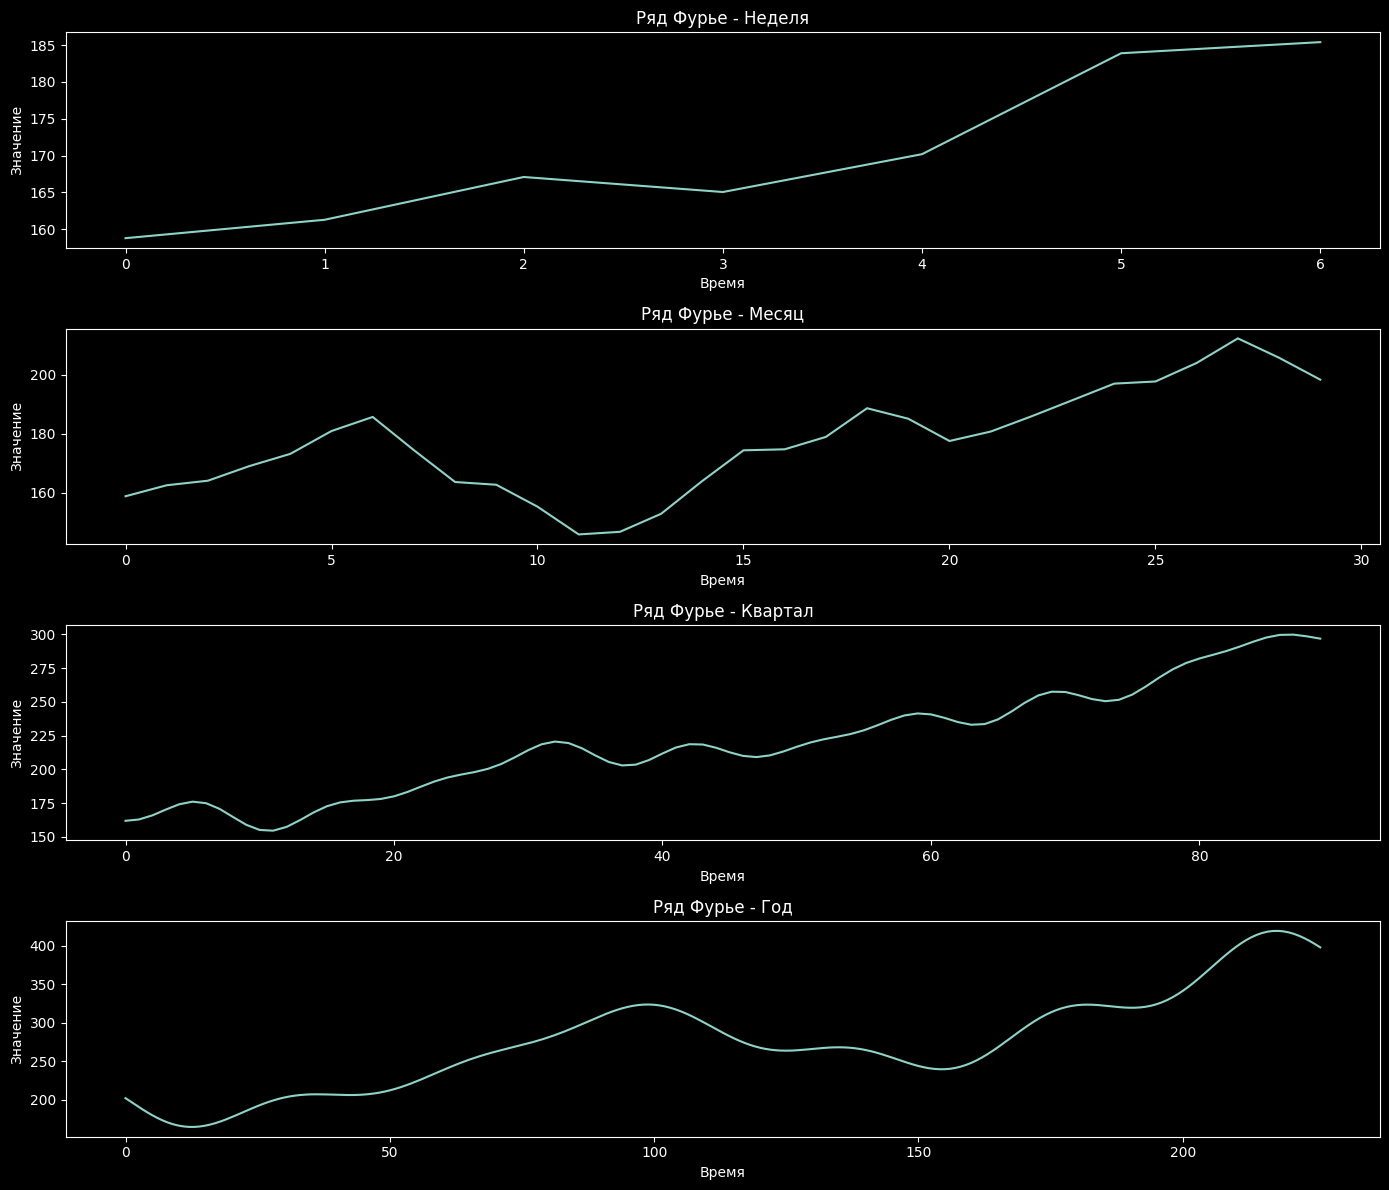

In [5]:
time_intervals = [
    {"ru": "Неделя", "en": "Week", "length": 7},
    {"ru": "Месяц", "en": "Month", "length": 30},
    {"ru": "Квартал", "en": "Quarter", "length": 90},
    {"ru": "Год", "en": "Year", "length": 365},
]

fig, axes = plt.subplots(nrows=len(time_intervals), figsize=(14, 12))

for interval, ax in zip(time_intervals, axes):
    data_interval = data[: interval["length"]]
    fourier = fourier_method(data_interval)

    g = sns.lineplot(fourier, ax=ax)
    g.set_title(f"Ряд Фурье - {interval['ru']}")
    g.set_xlabel("Время")
    g.set_ylabel("Значение")

plt.tight_layout()
plt.show()


2. Построить график гармоник для каждого периода (4 графика, содержащие гармоники).

In [6]:
def get_harmonic(x, n_harmonic=10):
    # Получаем размер входного массива
    n = x.size
    # Создаем массив временных меток от 0 до n-1
    t = np.arange(0, n)
    # Выполняем полиномиальную аппроксимацию первого порядка (линейный тренд)
    p = np.polyfit(t, x, 1)
    # Удаляем тренд из входного сигнала
    x_notrend = x - p[0] * t
    # Применяем быстрые преобразование Фурье к сигналу без тренда
    x_freqdom = fft.fft(x_notrend)
    # Получаем частоты для преобразования Фурье
    f = fft.fftfreq(n)
    # Создаем список индексов частотных компонент
    indexes = list(range(n))
    # Сортируем индексы по амплитуде (по убыванию)
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()
    # Инициализируем массив для восстановленного сигнала
    restored_sig = np.zeros(t.size)
    # Создаем список для гармоник
    harmonic_list = []
    # Для первых 1 + 2 * n_harmonic значимых гармоник
    for i in indexes[: 1 + n_harmonic * 2]:
        # Рассчитываем амплитуду и фазу текущей гармоники
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        # Восстанавливаем сигнал, добавляя текущую гармонику
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
        # Добавляем восстановленный сигнал с трендом в список гармоник
        harmonic_list.append(restored_sig + p[0] * t)
    # Возвращаем список гармоник
    return harmonic_list


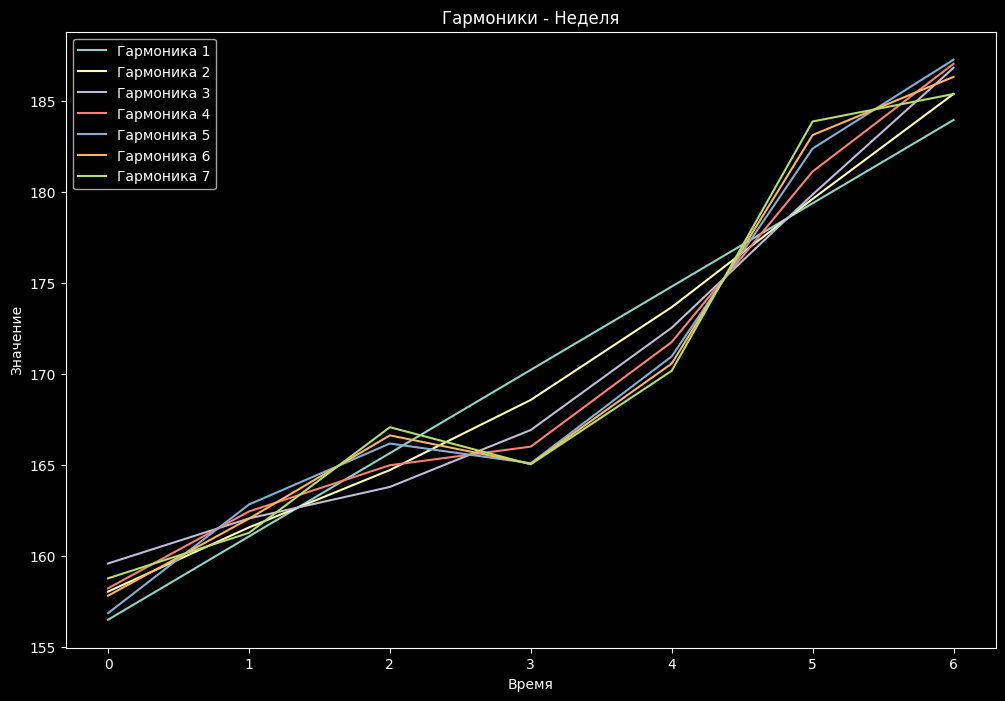

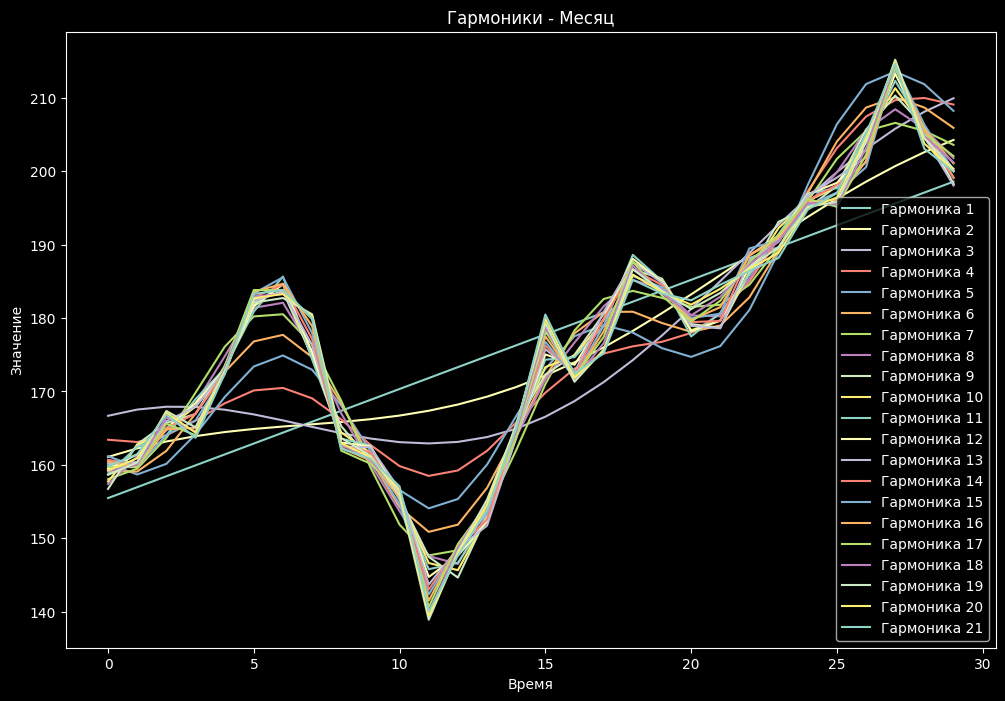

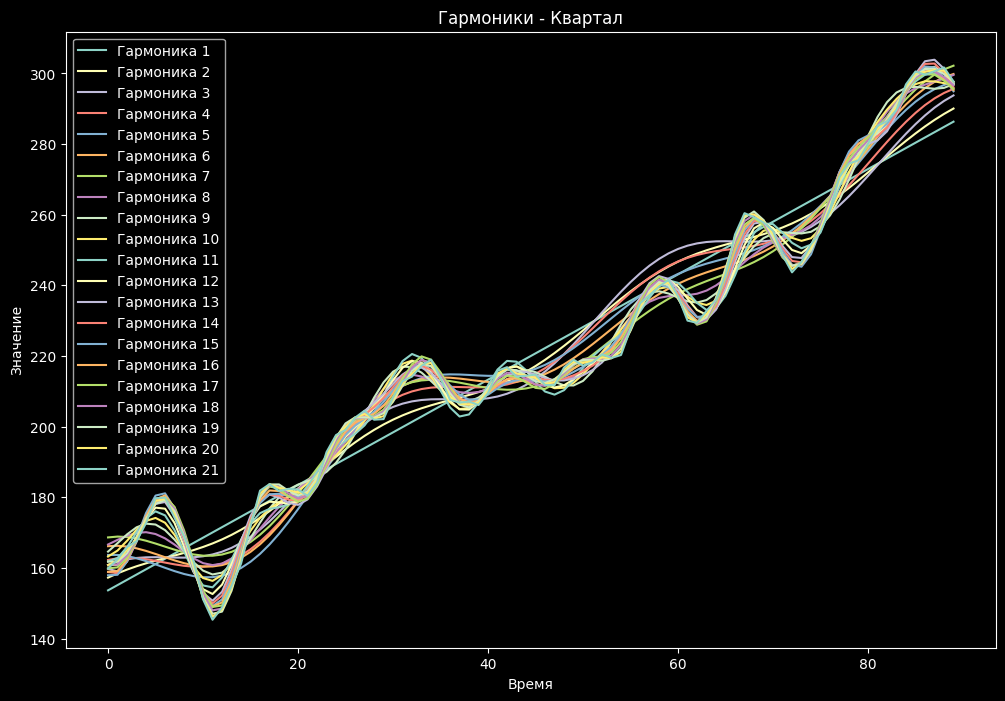

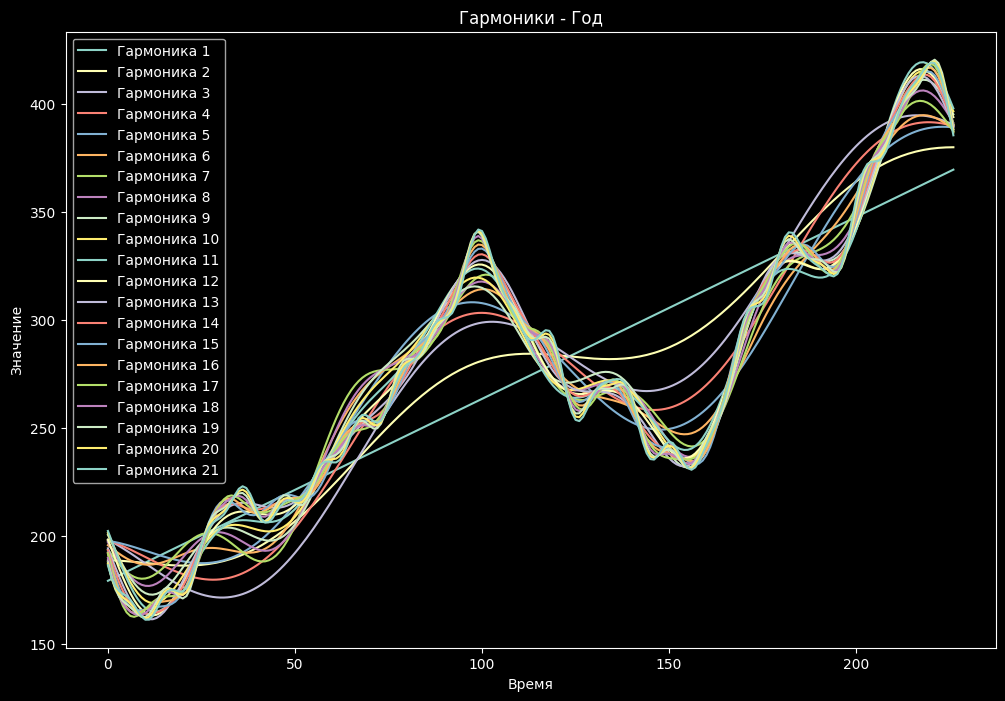

In [7]:
for interval in time_intervals:
    plt.figure(figsize=(12, 8))
    harm = get_harmonic(data[: interval["length"]])
    for i, graph in enumerate(harm):
        sns.lineplot(graph, label=f"Гармоника {i+1}")

    plt.title(f"Гармоники - {interval['ru']}")
    plt.xlabel("Время")
    plt.ylabel("Значение")

3. Построить график исходных значений и значений, полученных с помощью рядов Фурье (4 графика).

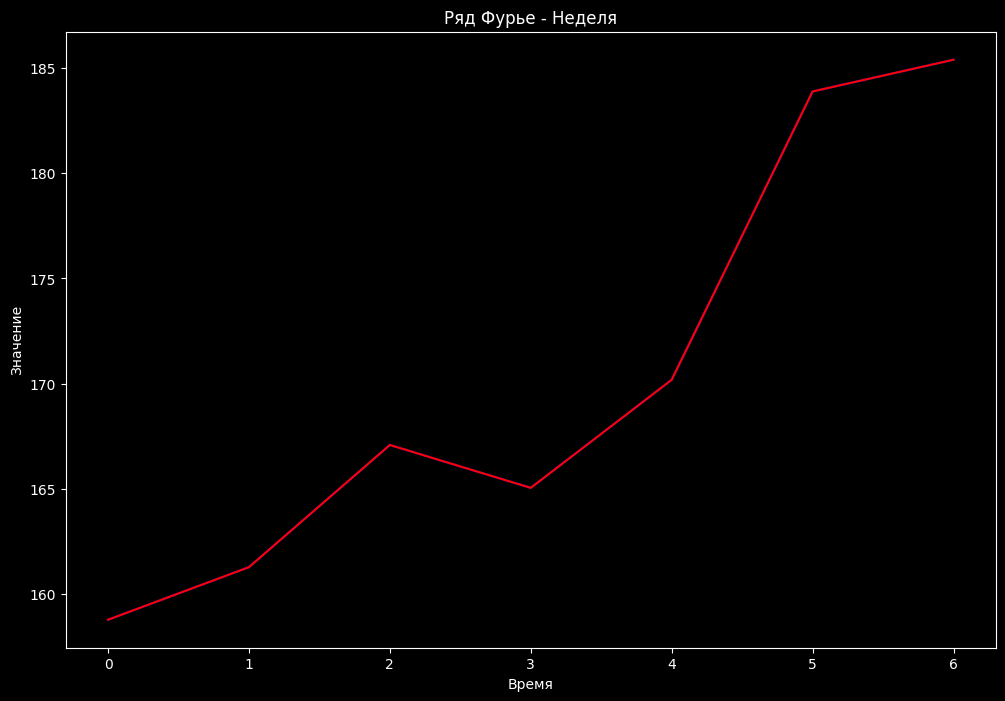

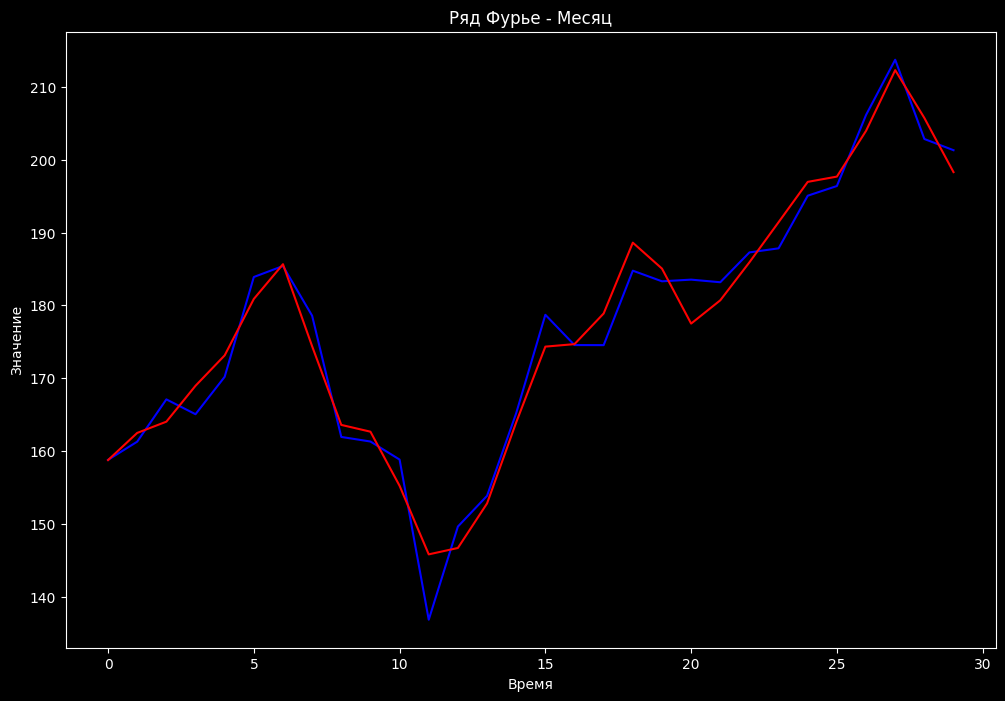

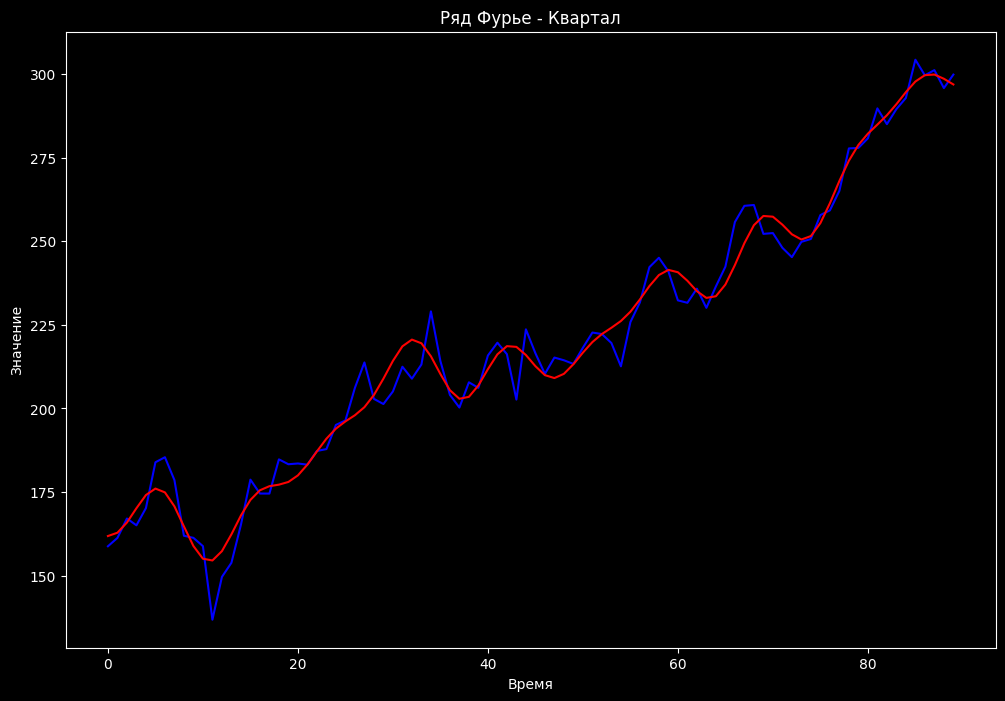

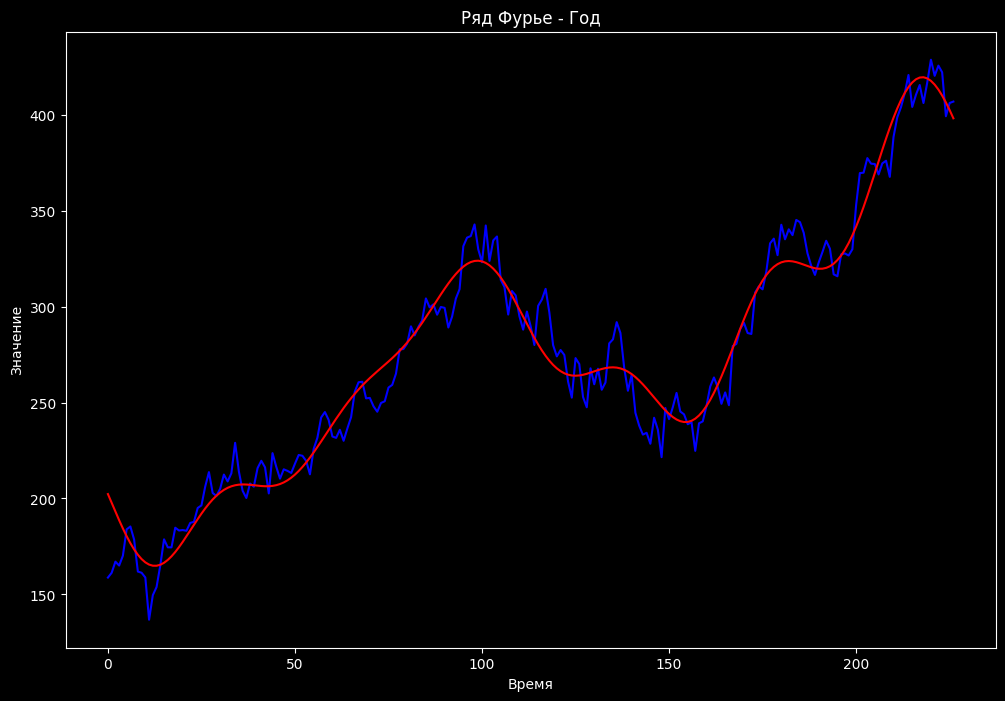

In [8]:
for interval in time_intervals:
    plt.figure(figsize=(12, 8))
    plt.plot(data[: interval["length"]], color="blue", label="Фактические значения")
    fourier = fourier_method(data[: interval["length"]])
    plt.plot(fourier, color="red", label="Полученные значения")

    plt.title(f"Ряд Фурье - {interval['ru']}")
    plt.xlabel("Время")
    plt.ylabel("Значение")


4. Определить число гармоник для каждого периода, позволяющих восстановить данные со средней относительной ошибкой аппроксимации не более 5%.

In [9]:
def harmonic_count(x, error_rate=5):
    n = x.size
    n_harmonic = n
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)

    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))

    indexes.sort(key=lambda i: np.absolute(f[i]))

    restored_sig = np.zeros(t.size)

    for i in indexes[: 1 + n_harmonic * 2]:
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)

        x_pred = restored_sig + p[0] * t
        error_approx = (abs(x_pred - x) / x_pred).sum() / n * 100
        if error_approx < error_rate:
            return error_approx, i + 1

In [11]:
for interval in time_intervals:
    error, h_count = harmonic_count(data[: interval["length"]])
    print(interval['ru'])
    print(f"  error: {error}")
    print(f"  harmonic_count: {h_count}\n")


Неделя
  error: 1.6316711728489612
  harmonic_count: 1

Месяц
  error: 3.9543314396438483
  harmonic_count: 2

Квартал
  error: 4.439824649057871
  harmonic_count: 1

Год
  error: 4.782501537988527
  harmonic_count: 5



5. Построить периодограмму (4 графика)

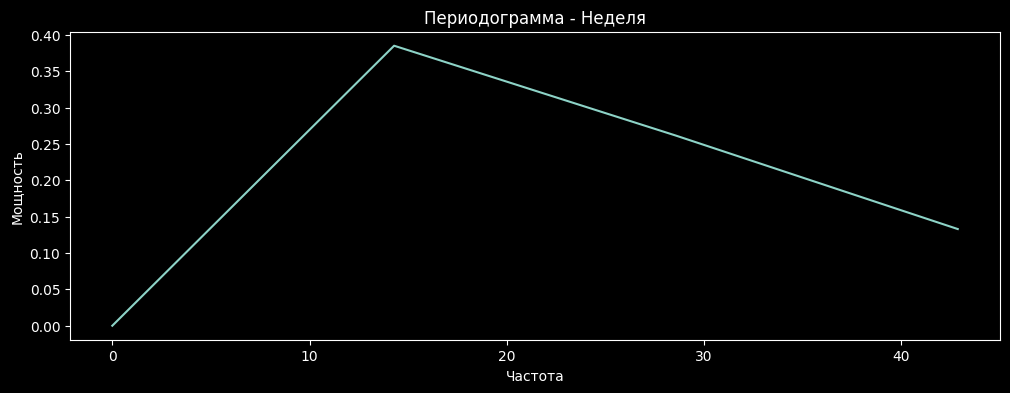

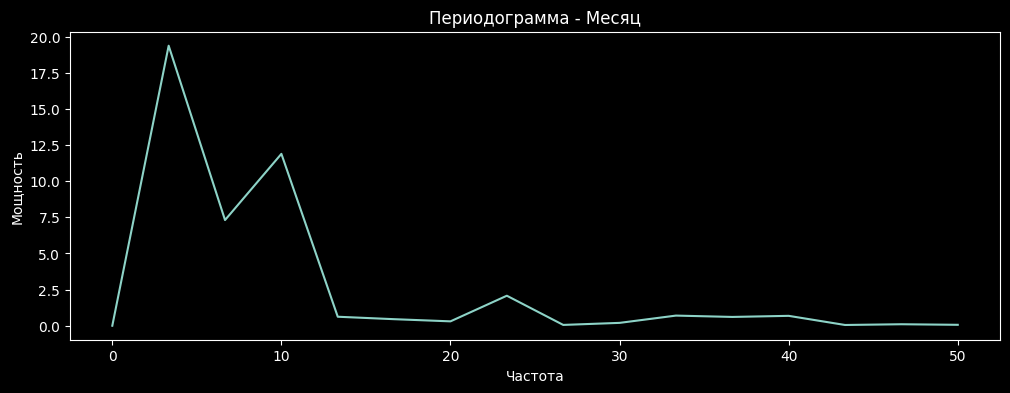

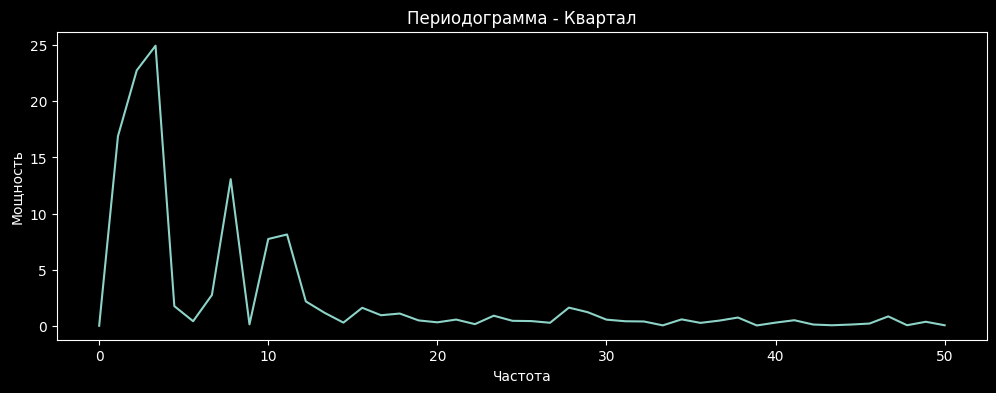

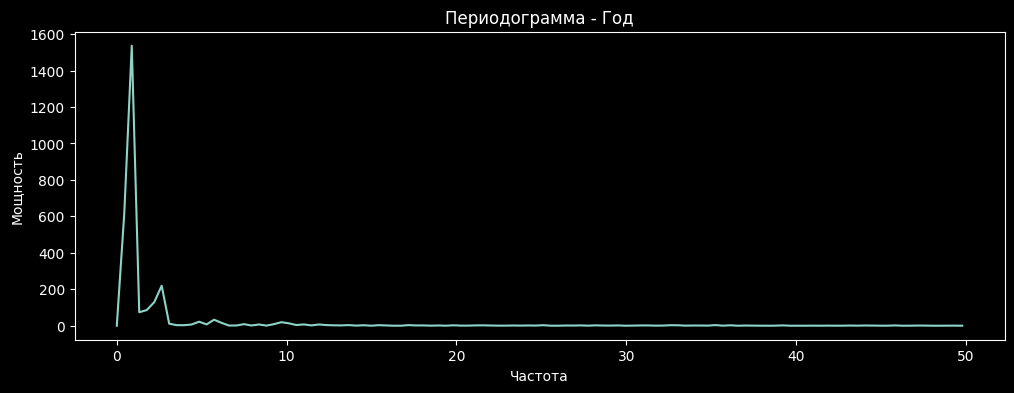

In [12]:
for interval in time_intervals:
    plt.figure(figsize=(12, 4))
    f, Px = sc.periodogram(data[:interval['length']], fs=100, detrend='linear')

    sns.lineplot(x=f, y=Px)
    plt.yscale='log'
    plt.title(f"Периодограмма - {interval['ru']}")
    plt.xlabel("Частота")
    plt.ylabel("Мощность")


6. Построить спектрограмму (4 графика)

In [13]:
def get_spectrogram(x, n_harmonic = 10, n_predict=0):
    n = x.size
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))

    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()

    phase_list = []
    t = np.arange(n + n_predict)
    for i in indexes[:1 + n_harmonic]:
        phase = np.angle(x_freqdom[i])
        phase_list.append(phase)
    return phase_list

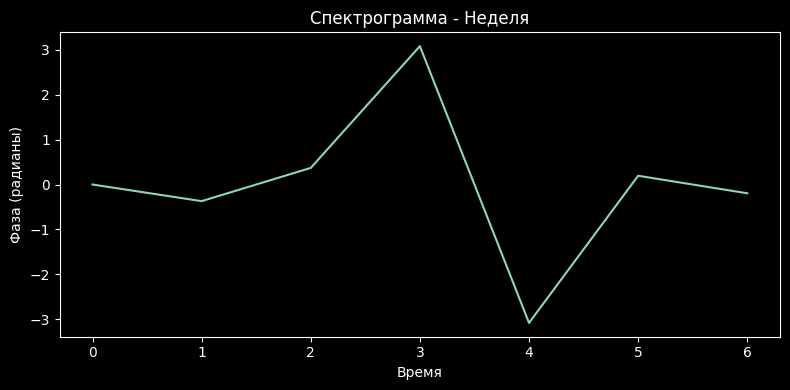

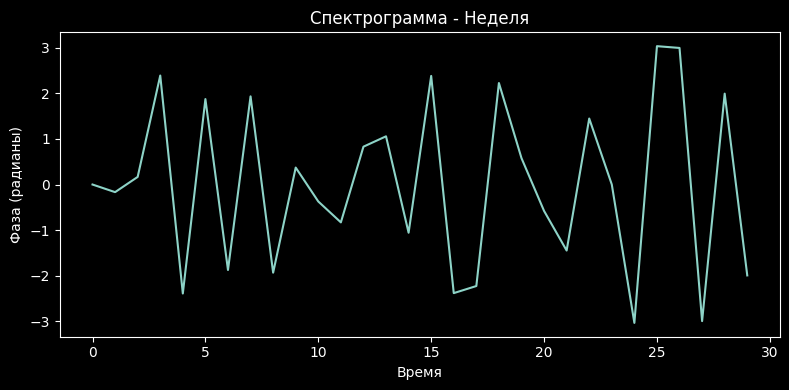

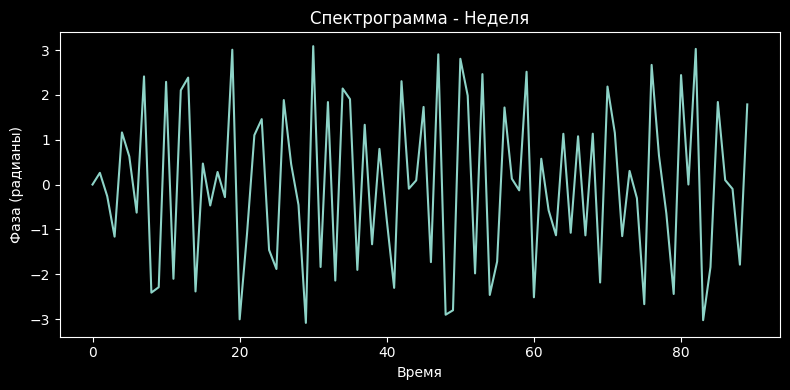

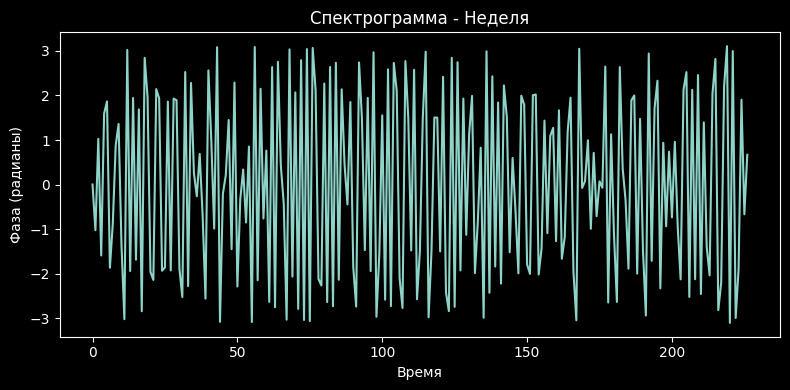

In [18]:
for interval in time_intervals:
    plt.figure(figsize=(8, 4))
    plt.plot(get_spectrogram(data[: interval["length"]], interval["length"]))
    plt.title("Cпектрограмма - Неделя")
    plt.xlabel("Время")
    plt.ylabel("Фаза (радианы)")
    plt.tight_layout()
    plt.show()


7. Построить прогноз на Т/4 вперед и назад, рассчитать ошибку прогноза.

Число гармоник: 23
Ошибка прогноза: 6.815826728517988


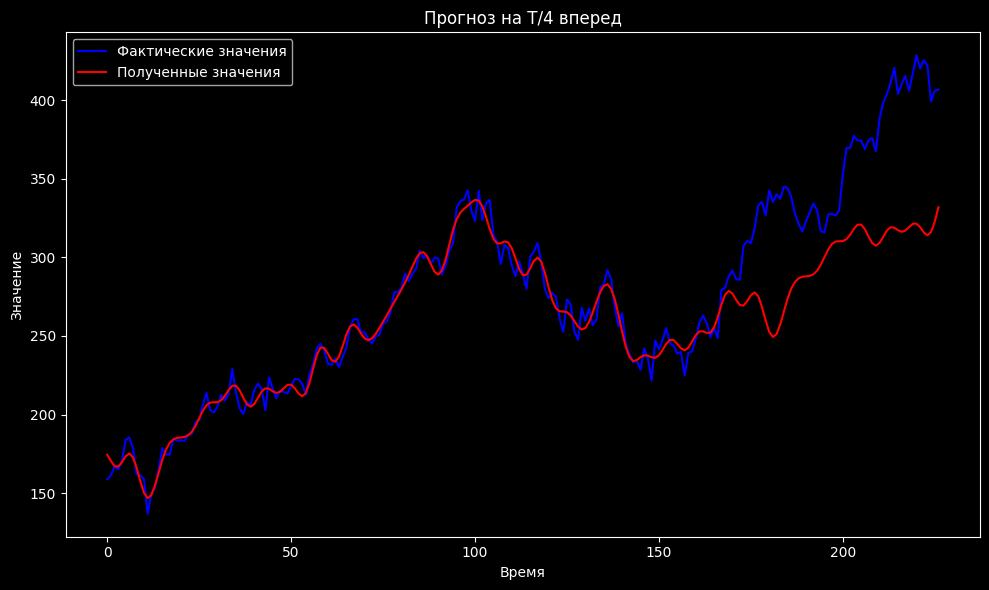

In [ ]:
n_pred = round(len(data) / 4)
c_harm = harmonic_count(data[:-n_pred], 2)[1]
print("Число гармоник:", c_harm)
fourier_forward = fourier_method(data[:-n_pred], c_harm, n_pred)

x_pred = fourier_forward[len(data) - n_pred :]
error_approx = (
    (abs(x_pred - data[len(data) - n_pred :]) / x_pred).sum()
    / (len(data) - n_pred)
    * 100
)
print("Ошибка прогноза:", error_approx)

plt.figure(figsize=(10, 6))
plt.plot(data, color="blue", label="Фактические значения")
plt.plot(fourier_forward, color="red", label="Полученные значения")
plt.title("Прогноз на T/4 вперед")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
def fourier_method_back(x, n_harmonic=10, n_predict=0):
    # Получаем размер входного массива
    n = x.size
    # Создаем массив временных меток от 0 до n-1
    t = np.arange(0, n)
    # Выполняем полиномиальную аппроксимацию первого порядка (линейный тренд)
    p = np.polyfit(t, x, 1)
    # Удаляем тренд из входного сигнала
    x_notrend = x - p[0] * t
    # Применяем быстрое преобразование Фурье к сигналу без тренда
    x_freqdom = fft.fft(x_notrend)
    # Получаем частоты для преобразования Фурье
    f = fft.fftfreq(n)
    # Создаем список индексов частотных компонент
    indexes = list(range(n))
    # Сортируем индексы по амплитуде (по убыванию)
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()
    # Создаем массив временных меток для предсказания на прошлое (обратное предсказание)
    t_pred_backward = np.arange(-n_predict, n)
    # Инициализируем массив для восстановленного сигнала с предсказанием
    restored_sig_backward = np.zeros(t_pred_backward.size)
    # Для первых 1 + n_harmonic значимых гармоник
    for i in indexes[: 1 + n_harmonic]:
        # Рассчитываем амплитуду и фазу текущей гармоники
        ampli = np.absolute(x_freqdom[i]) / n
        phase = np.angle(x_freqdom[i])

        # Восстанавливаем сигнал, добавляя текущую гармонику с учетом времени для обратного предсказания
        restored_sig_backward += ampli * np.cos(
            2 * np.pi * f[i] * t_pred_backward + phase
        )

    # Добавляем тренд к восстановленному сигналу для получения итогового предсказания
    prediction_backward = restored_sig_backward + p[0] * t_pred_backward
    # Возвращаем восстановленный сигнал с предсказанием на прошлое
    return prediction_backward


Число гармоник: 17
Ошибка прогноза: 5.768695958820551


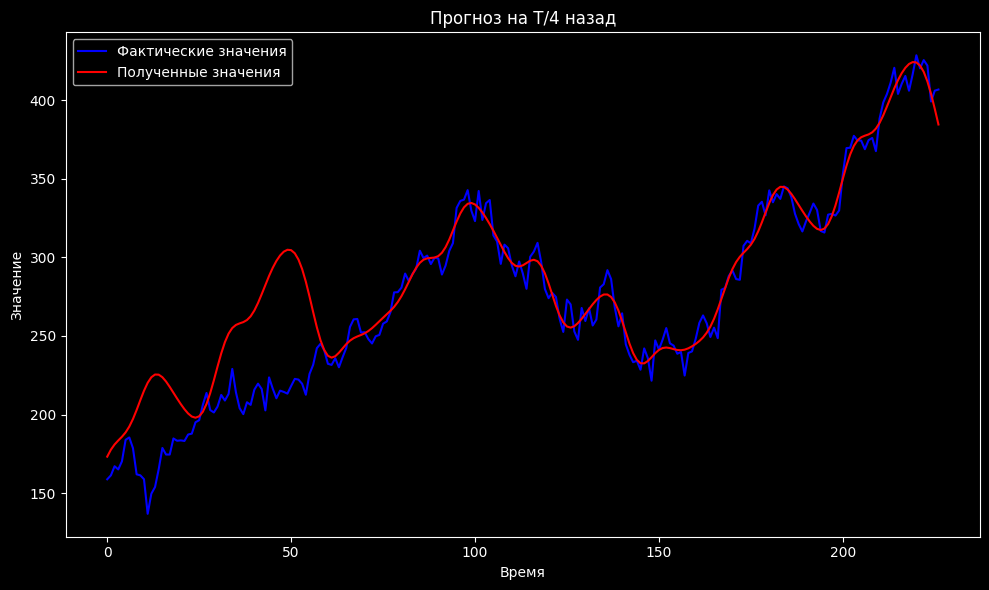

In [ ]:
n_pred = round(len(data)/4)
c_harm = harmonic_count(data[n_pred:], 2)[1]
print("Число гармоник:", c_harm)
fourier_backward = fourier_method_back(data[n_pred:], c_harm, n_pred)

x_pred = fourier_backward[:n_pred]
error_approx = (abs(x_pred - data[:n_pred])/x_pred).sum()/(len(data)-n_pred) * 100
print("Ошибка прогноза:", error_approx)

plt.figure(figsize=(10, 6))
plt.plot(data, color = 'blue', label = 'Фактические значения')
plt.plot(fourier_backward, color = 'red', label = 'Полученные значения')
plt.title("Прогноз на T/4 назад")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.tight_layout()
plt.legend()
plt.show()